## 1. Imports


In [1]:
import os
import sys
import gc
import json
import warnings

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from PIL import PngImagePlugin

from IPython.display import clear_output

sys.path.append("..")
from src.losses import VGGPerceptualLoss as VGGLoss
from src.resnet2 import ResNet_D
from src.unet import UNet
from src.u2net import U2NET

from src.tools import (
    set_random_seed,
    weights_init_D,
    get_pushed_loader_metrics,
    get_pushed_loader_stats,
)
from src.fid_score import calculate_frechet_distance
from src.samplers import get_paired_sampler
from src.plotters import (
    plot_pushed_images,
    plot_pushed_random_paired_images,
)


LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

warnings.filterwarnings("ignore")

%matplotlib inline 

In [2]:
gc.collect()
torch.cuda.empty_cache()

## 2. Init Config and FID stats

the config file `config.json` is saved at saved_models/EXP_NAME/

In [42]:
SEED = 0x3060
set_random_seed(SEED)

# dataset choosing
# face2comic
# DATASET, DATASET_PATH, MAP_NAME, REVERSE = (
#     "comic_faces_v1",
#     "../datasets/face2comics_v1.0.0_by_Sxela",
#     "face2comic",
#     False,
# )
# colored mask -> face
# DATASET, DATASET_PATH, MAP_NAME, REVERSE = (
#     "celeba_mask",
#     "../datasets/CelebAMask-HQ",
#     "colored_mask2face",
#     False,
# )
# sketch -> photo
DATASET, DATASET_PATH, MAP_NAME, REVERSE = (
    "FS2K",
    "../datasets/FS2K/",
    "sketch2photo",
    False,
)

IMG_SIZE = 256
DATASET1_CHANNELS = 3
DATASET2_CHANNELS = 3

# GPU choosing
DEVICE_IDS = [1]
assert torch.cuda.is_available()
torch.cuda.set_device(f"cuda:{DEVICE_IDS[0]}")

CONTINUE = 0

# All hyperparameters below is set to the values used for the experiments, which discribed in the article

# training algorithm settings
BATCH_SIZE = 32
T_ITERS = 10
MAX_STEPS = 30000 + 1  # 2501 for testing
COST = "vgg"  #'mse' # 'mae' # 'vgg'

# network settings
T_TYPE = "U2Net"  # 'UNet' # or  ('ResNet_pix2pix' - not implemented)
D_TYPE = (
    "ResNet"  # or 'ResNet_pix2pix' - DOES NOT WORK WELL (it is actually not a resnet:)
)

D_NORM = "none"  # For our ResNet_D uses the "batchnorm" or "none".
CONDITIONAL = False  # Test conditional NOT (not needed anymore)
NOT = True  # Train Neural optimal transport or pure regression

# plot settings
GRAY_PLOTS = False

FID_EPOCHS = 1

EXP_NAME = f"GNOT_Paired_{DATASET}_{SEED}"
OUTPUT_PATH = f"../saved_models/{EXP_NAME}/"

if not os.path.exists(OUTPUT_PATH):
    raise "no such file or directory"

In [4]:
if COST == "vgg":
    vgg_loss = VGGLoss().cuda()

### load FID stats

In [5]:
use_Y = not REVERSE
if use_Y:
    filename = f"../stats/{DATASET}_{MAP_NAME.split('2')[1]}_{IMG_SIZE}_test.json"
else:
    filename = f"../stats/{DATASET}_{MAP_NAME.split('2')[0]}_{IMG_SIZE}_test.json"

with open(filename, "r") as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats["mu"], data_stats["sigma"]
del data_stats

## 3. Initialize samplers


In [43]:
_, XY_test_sampler = get_paired_sampler(
    DATASET, DATASET_PATH, img_size=IMG_SIZE, reverse=REVERSE, batch_size=BATCH_SIZE
)

torch.cuda.empty_cache()
gc.collect()
clear_output()

## 4. Testing


### init models

In [7]:
if D_TYPE == "ResNet":
    D = ResNet_D(
        IMG_SIZE,
        nc=3 if not CONDITIONAL else 6,
        bn=D_NORM != "none",
    ).cuda()
    D.apply(weights_init_D)
else:
    raise NotImplementedError("Unknown D_TYPE: {}".format(D_TYPE))

if T_TYPE == "UNet":
    T = UNet(DATASET1_CHANNELS, DATASET2_CHANNELS, base_factor=48).cuda()
elif T_TYPE == "U2Net":
    T = U2NET(in_ch=DATASET1_CHANNELS, out_ch=DATASET2_CHANNELS).cuda()
else:
    raise NotImplementedError("Unknown T_TYPE: {}".format(T_TYPE))

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    D = nn.DataParallel(D, device_ids=DEVICE_IDS)

print("T params:", np.sum([np.prod(p.shape) for p in T.parameters()]))
print("D params:", np.sum([np.prod(p.shape) for p in D.parameters()]))

T params: 44008779
D params: 41811905


### load weights

In [47]:
print("Loading weights")

w_path = os.path.join(OUTPUT_PATH, f"T_{SEED}_30000.pt")  # user setting

T.load_state_dict(torch.load(w_path))

print(f"{w_path}, loaded")

Loading weights
../saved_models/GNOT_Paired_FS2K_12384/T_12384_30000.pt, loaded


### Plots Test

In [45]:
X_test_fixed, Y_test_fixed = XY_test_sampler.sample(10)

### Plots Test


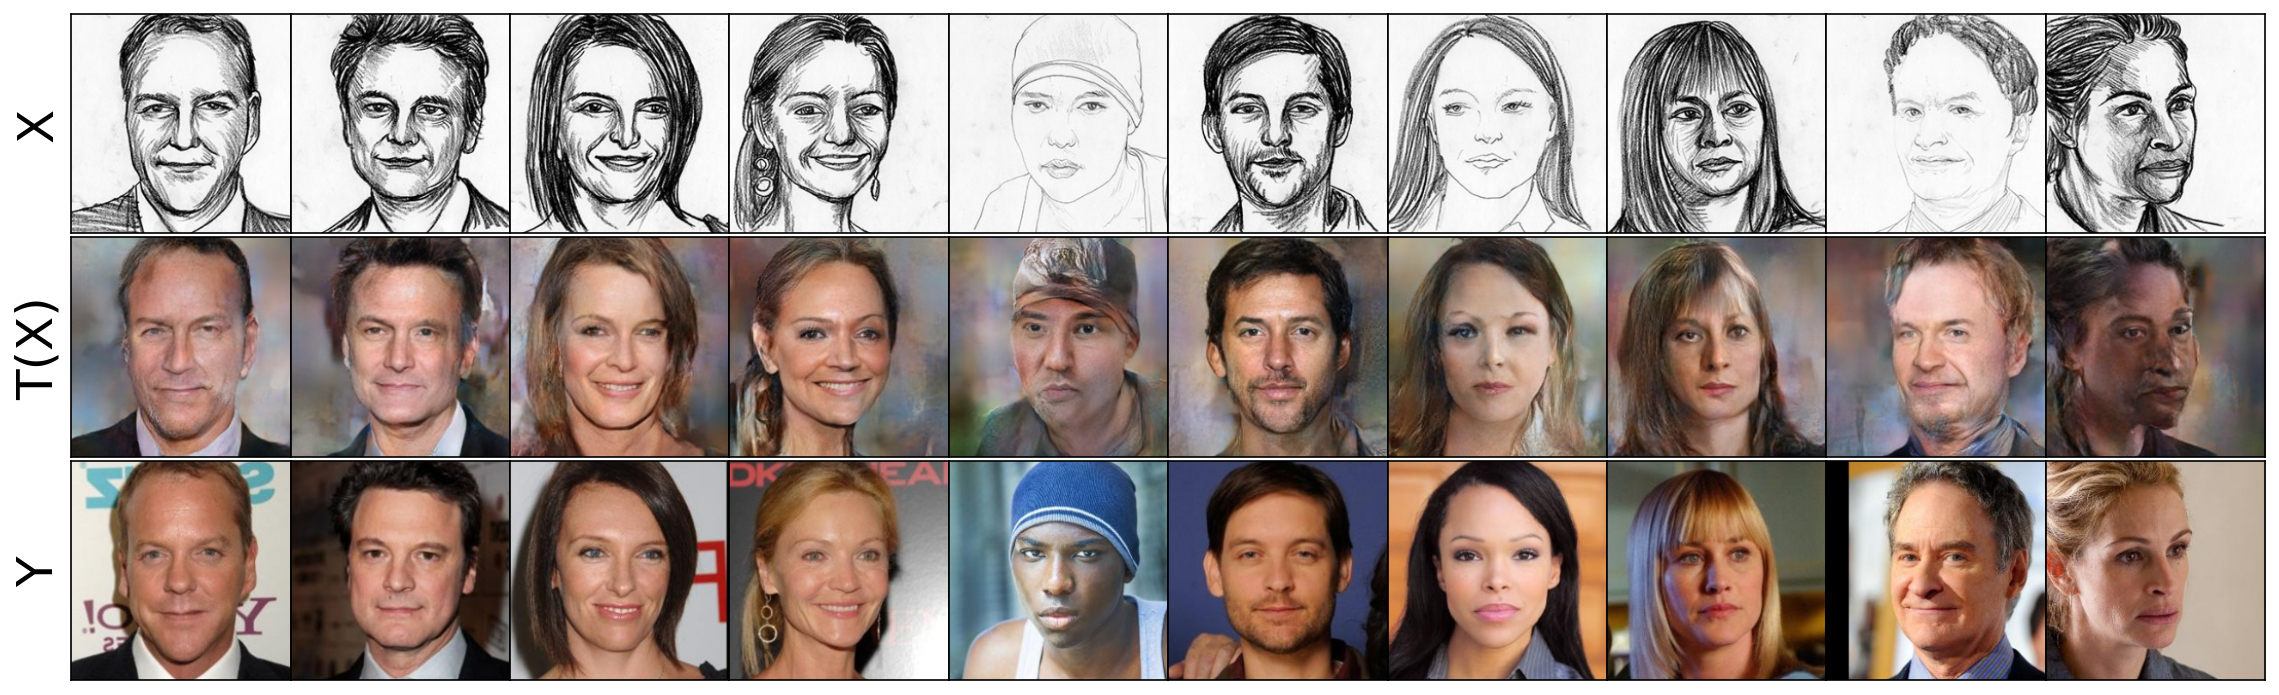

In [48]:
fig, axes = plot_pushed_images(X_test_fixed, Y_test_fixed, T)

In [ ]:
fig, axes = plot_pushed_random_paired_images(XY_test_sampler, T)

### main testing


In [ ]:
clear_output(wait=True)
print("Plotting")

inference_T = T
inference_T.eval()

print("Fixed Test Images")
fig, axes = plot_pushed_images(X_test_fixed, Y_test_fixed, inference_T, gray=GRAY_PLOTS)
plt.show(fig)
plt.close(fig)

print("Random Test Images")
fig, axes = plot_pushed_random_paired_images(
    XY_test_sampler, inference_T, gray=GRAY_PLOTS
)
plt.show(fig)
plt.close(fig)

In [ ]:
print("Computing FID")
gen_mu, gen_sigma = get_pushed_loader_stats(
    T,
    XY_test_sampler.loader,
    n_epochs=FID_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=True,
)
fid = calculate_frechet_distance(gen_mu, gen_sigma, target_mu, target_sigma)
print(f"FID={fid}")
del gen_mu, gen_sigma

In [ ]:
print("Computing Metrics")
metrics = get_pushed_loader_metrics(
    T,
    XY_test_sampler.loader,
    n_epochs=FID_EPOCHS,
    verbose=True,
    log_metrics=["LPIPS", "PSNR", "SSIM", "MSE", "MAE"],
)
print(f"metrics={metrics}")